In [ ]:
#!pip install py_vollib_vectorized

In [1]:
import numpy as np 
from scipy import integrate 
import time 
import pandas as pd 
import py_vollib_vectorized
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.special import erf
from scipy import optimize
from scipy.stats import norm


In [2]:
#load in option data
SPX = pd.read_csv(r"C:\Users\Martin Weirich\OneDrive\Dokumente\MScMathFinance\TopicsInQuantFinance\CBOESPXOptions2019.csv",
                 parse_dates=['date','exdate'],
                  usecols=['date','exdate','cp_flag','strike_price','best_bid','best_bid','best_offer','volume','forward_price'])

In [3]:
#borrow some code from Vlad's notebooks
def vol_slice_extractor(date, expiry_index, middle_percent=0.8):
    
    surface_for_date = otm_options.groupby('date').get_group(date)
    expiry=list(surface_for_date.groupby('exdate').groups.keys())[expiry_index]
    vol_slice = surface_for_date.groupby('exdate').get_group(expiry).sort_values(by='strike_price').set_index('strike_price')[['bid_vols','offer_vols']]
    fwd = surface_for_date.groupby('exdate').get_group(expiry).sort_values(by='strike_price').set_index('strike_price')['impl_fw'].iat[0]

    vol_strikes = vol_slice.index
    upper = vol_strikes[vol_strikes>fwd]
    lower = vol_strikes[vol_strikes<fwd]
    upper_strike=upper[int(len(upper)*middle_percent)]
    lower_strike=lower[-int(len(lower)*middle_percent)]

    see=vol_slice[(vol_slice.index>lower_strike)&(vol_slice.index<upper_strike)]


    return vol_slice[(vol_slice.index>lower_strike)&(vol_slice.index<upper_strike)], expiry, fwd

In [4]:
#filter option data a little , since the laborde method only uses calls , drop all puts
SPX=SPX[(SPX.best_bid > 0.) & (SPX.date < SPX.exdate)]


SPX.loc[:,'strike_price'] /= 1000.
SPX.loc[:,'cp_flag'] = SPX['cp_flag'].str.lower() # compatibility with lowercase p/c in py_vollib_vectorized
SPX['mid_price'] = (SPX['best_bid'] + SPX['best_offer']) * 0.5
SPX['impl_SPX'] = np.NaN
SPX['impl_fw'] = np.NaN
SPX = SPX[SPX.cp_flag !='p']
SPX.head(10)


,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,forward_price,mid_price,impl_SPX,impl_fw
0,2019-01-02,2019-01-18,c,1000.0,1502.8,1508.2,800,2511.210405,1505.50,NaN,NaN
1,2019-01-02,2019-01-18,c,1025.0,1477.8,1483.2,0,2511.210405,1480.50,NaN,NaN
2,2019-01-02,2019-01-18,c,1050.0,1452.9,1458.2,0,2511.210405,1455.55,NaN,NaN
3,2019-01-02,2019-01-18,c,1075.0,1427.9,1433.3,0,2511.210405,1430.60,NaN,NaN
4,2019-01-02,2019-01-18,c,1100.0,1402.9,1408.3,0,2511.210405,1405.60,NaN,NaN
5,2019-01-02,2019-01-18,c,1125.0,1378.0,1383.3,0,2511.210405,1380.65,NaN,NaN
6,2019-01-02,2019-01-18,c,1150.0,1353.0,1358.4,0,2511.210405,1355.70,NaN,NaN
7,2019-01-02,2019-01-18,c,1175.0,1328.0,1333.4,0,2511.210405,1330.70,NaN,NaN
8,2019-01-02,2019-01-18,c,1200.0,1303.1,1308.5,0,2511.210405,1305.80,NaN,NaN
9,2019-01-02,2019-01-18,c,1225.0,1278.1,1283.5,0,2511.210405,1280.80,NaN,NaN


In [5]:
#extract data for one single day
SPX_one_day = SPX[SPX.date == np.datetime64('2019-01-02')]
SPX_one_day


,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,forward_price,mid_price,impl_SPX,impl_fw
0,2019-01-02,2019-01-18,c,1000.0,1502.8,1508.2,800,2511.210405,1505.50,NaN,NaN
1,2019-01-02,2019-01-18,c,1025.0,1477.8,1483.2,0,2511.210405,1480.50,NaN,NaN
2,2019-01-02,2019-01-18,c,1050.0,1452.9,1458.2,0,2511.210405,1455.55,NaN,NaN
3,2019-01-02,2019-01-18,c,1075.0,1427.9,1433.3,0,2511.210405,1430.60,NaN,NaN
4,2019-01-02,2019-01-18,c,1100.0,1402.9,1408.3,0,2511.210405,1405.60,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15028,2019-01-02,2019-12-31,c,3000.0,24.2,26.5,0,2544.864708,25.35,NaN,NaN
15029,2019-01-02,2019-12-31,c,3100.0,14.5,16.4,16,2544.864708,15.45,NaN,NaN
15030,2019-01-02,2019-12-31,c,3200.0,8.7,10.2,0,2544.864708,9.45,NaN,NaN
15031,2019-01-02,2019-12-31,c,3300.0,5.3,6.4,0,2544.864708,5.85,NaN,NaN


In [6]:
expiries = list(SPX_one_day.groupby('exdate').groups.keys())
print(expiries)

[Timestamp('2019-01-04 00:00:00'), Timestamp('2019-01-07 00:00:00'), Timestamp('2019-01-09 00:00:00'), Timestamp('2019-01-11 00:00:00'), Timestamp('2019-01-14 00:00:00'), Timestamp('2019-01-16 00:00:00'), Timestamp('2019-01-18 00:00:00'), Timestamp('2019-01-22 00:00:00'), Timestamp('2019-01-23 00:00:00'), Timestamp('2019-01-25 00:00:00'), Timestamp('2019-01-28 00:00:00'), Timestamp('2019-01-30 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2019-02-01 00:00:00'), Timestamp('2019-02-04 00:00:00'), Timestamp('2019-02-06 00:00:00'), Timestamp('2019-02-08 00:00:00'), Timestamp('2019-02-15 00:00:00'), Timestamp('2019-02-22 00:00:00'), Timestamp('2019-02-28 00:00:00'), Timestamp('2019-03-15 00:00:00'), Timestamp('2019-03-29 00:00:00'), Timestamp('2019-04-18 00:00:00'), Timestamp('2019-04-30 00:00:00'), Timestamp('2019-05-31 00:00:00'), Timestamp('2019-06-21 00:00:00'), Timestamp('2019-06-28 00:00:00'), Timestamp('2019-09-20 00:00:00'), Timestamp('2019-09-30 00:00:00'), Timestamp('20

In [7]:
tester = SPX_one_day[SPX_one_day.exdate == expiries[0]]
tester = tester[tester.volume !=0]
first_slice = tester.sort_values('strike_price').reset_index(drop = 'True')
delta = first_slice.loc[0,'exdate'] - first_slice.loc[0,'date']
t_1 = delta.days
first_slice


,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,forward_price,mid_price,impl_SPX,impl_fw
0,2019-01-02,2019-01-04,c,2000.0,503.90,509.00,7,2510.182809,506.450,NaN,NaN
1,2019-01-02,2019-01-04,c,2220.0,283.90,289.50,1,2510.182809,286.700,NaN,NaN
2,2019-01-02,2019-01-04,c,2225.0,278.90,284.50,1,2510.182809,281.700,NaN,NaN
3,2019-01-02,2019-01-04,c,2240.0,263.90,269.50,1,2510.182809,266.700,NaN,NaN
4,2019-01-02,2019-01-04,c,2250.0,254.50,259.70,3,2510.182809,257.100,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
57,2019-01-02,2019-01-04,c,2615.0,0.05,0.15,714,2510.182809,0.100,NaN,NaN
58,2019-01-02,2019-01-04,c,2620.0,0.05,0.15,1247,2510.182809,0.100,NaN,NaN
59,2019-01-02,2019-01-04,c,2625.0,0.05,0.15,2838,2510.182809,0.100,NaN,NaN
60,2019-01-02,2019-01-04,c,2630.0,0.05,0.10,165,2510.182809,0.075,NaN,NaN


In [8]:
S_0 = 2510.03 #googled close of SPX for 2nd jan 2019
#calculate sigma_0 to calculate next slice P_1

def sigma_objective(sigma , first_slice, S_0, sqrtt):
    help_v = (first_slice.strike_price-S_0)/(np.sqrt(2)*sqrtt*sigma)
    B_vec = 0.5*(S_0-first_slice.strike_price)*erf(help_v)+ sigma*sqrtt/np.sqrt(2*np.pi)*np.exp(-help_v**2)
    return np.sum((B_vec-first_slice.mid_price)**2)


def calculate_sigma_0(first_slice, expiries,S_0):
    delta = first_slice.loc[0,'exdate'] - first_slice.loc[0,'date']
    sqrtt = np.sqrt(delta.days)
    res = optimize.minimize_scalar(sigma_objective,args = (first_slice , S_0, sqrtt))
    return res.x

sigma_0 = calculate_sigma_0(SPX_one_day, expiries , S_0)
print(sigma_0)



337.1647484033721


In [10]:
#construct P_1 as a discrete measure 
#first some helpful constants 
K = first_slice.strike_price
mid = first_slice.mid_price
delta_C_bid = first_slice.mid_price-first_slice.best_bid
delta_C_ask = first_slice.mid_price-first_slice.best_offer
w = 0.1*np.abs(first_slice.best_offer-first_slice.best_bid)

#define prior m_0
def m_0(s,S_0,sigma_0,t_1):
    #renormalise m_0 on R^+
    return norm.pdf(s,S_0,sigma_0*np.sqrt(t_1))/norm.cdf(S_0/(sigma_0*np.sqrt(t_1))) if s>=0 else 0

#initial guesses 
u_0, theta_0, V = 0, 0 , np.zeros(K.size)

#calculate u as in remark 4.2 for the special case P_0 = dirac centered in S_0 

def u_integrand(s,theta,V,K,S_0,sigma_0,t_1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S_0))*m_0(s,S_0,sigma_0,t_1)

u_0 = -np.log(S_0)+np.log(integrate.quad(u_integrand,0,S_0+3*sigma_0,args=(theta_0,V,K,S_0,sigma_0,t_1) )[0])

print(u_0)



def I_h_0_integrand(s,theta,V,K,S_0,sigma_0,t_1):
     return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S_0))*m_0(s,S_0,sigma_0,t_1)*(s-S_0)

def I_h_0(theta_0,V,K,S_0,sigma_0,t_1):
    return integrate.quad(I_h_0_integrand,0,S_0+3*sigma_0,args=(theta_0,V,K,S_0,sigma_0,t_1))[0]

def I_h_0_grad_integrand(s,theta,V,K,S_0,sigma_0,t_1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S_0))*m_0(s,S_0,sigma_0,t_1)*(s-S_0)*(s-S_0)
    

def I_h_0_grad(theta_0,V,K,S_0,sigma_0,t_1):
    return integrate.quad(I_h_0_grad_integrand,0,S_0+3*sigma_0,args=(theta_0,V,K,S_0,sigma_0,t_1))[0]

def I_h_0_hessian_integrand(s,theta,V,K,S_0,sigma_0,t_1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S_0))*m_0(s,S_0,sigma_0,t_1)*(s-S_0)*(s-S_0)*(s-S_0)

def I_h_0_hessian(theta_0,V,K,S_0,sigma_0,t_1):
    return integrate.quad(I_h_0_hessian_integrand,0,S_0+3*sigma_0,args=(theta_0,V,K,S_0,sigma_0,t_1))[0]
    
    

    
theta_0 = optimize.root_scalar(I_h_0,args=(V,K,S_0,sigma_0,t_1) ,bracket = [0,0.0001],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root

print(theta_0)

print(I_h_0(theta_0,V,K,S_0,sigma_0,t_1))


-7.8451426632861505
1.601292148771045e-06
-3.453364882943788e-08


In [ ]:
# now minimisation for V
V = np.zeros(K.size)
def f_1(V,w,delta_C_bid,delta_C_ask):
    running_sum = 0 
    for i in range(0,V.size):
        if V[i]*w[i] <= delta_C_ask[i] and delta_C_bid[i]<= V[i]*w[i]:
            running_sum+= 0.5*w[i]*V[i]*V[i]
        if V[i]*w[i] > delta_C_ask[i]:
            running_sum+= delta_C_ask[i]*V[i] - 0.5/w[i]*delta_C_ask[i]*delta_C_ask[i]
        if V[i]*w[i] < delta_C_bid[i]:
            running_sum+= delta_C_bid[i]*V[i] - 0.5/w[i]*delta_C_bid[i]*delta_C_bid[i]
    return running_sum

def integrand_G_1(s,S_0,K,sigma_0,t_1,u_0,theta_0):
    return m_0(s,S_0,sigma_0,t_1)*np.exp(-np.sum(V*np.maximum(s-K,0)-u_0-theta_0*(s-S_0)))

def G_1(V,u_0,theta_0,K,delta_C_bid,delta_C_ask,w,S_0,sigma_0,t_1,mid):
    expectation = integrate.quad(integrand_G_1,0,S_0+3*sigma_0,args=(S_0,K,sigma_0,t_1,u_0,theta_0))[0]
    return u_0+np.sum(V*mid)+f_1(V,w,delta_C_bid,delta_C_ask)+expectation

res = optimize.minimize(G_1,x0=V,args=(u_0,theta_0,K,delta_C_bid,delta_C_ask,w,S_0,sigma_0,t_1,mid))

print(res)

V = res.x


In [ ]:
#using V,u_0,h_0=theta_0 construct P_1:

def P_1(s,K,S_0,V,u_0,theta_0,sigma_0,t_1):
    help_v = -np.sum(V*np.maximum(s-K,0)-u_0-theta_0*(s-S_0))
    return m_0(s,S_0,sigma_0,t_1)*np.exp(help_v)



In [ ]:
prices = []

for k in K:
    pricingfunction = lambda s: np.max(s-k,0)*P_1(s,K,S_0,V,u_0,theta_0,sigma_0,t_1)
    price = integrate.quad(pricingfunction,K[0],S_0+2*sigma_0*np.sqrt(t_1))[0]
    prices.append(price)

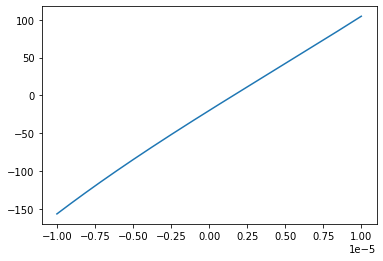

In [13]:

xx = np.linspace(-0.00001,0.00001,400)
yy = []
for x in xx:
    yy.append(I_h_0(x,V,K,S_0,sigma_0,t_1))

plt.plot(xx,yy)


In [ ]:
print(prices)
print(K)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(K,prices)
plt.plot(K,mid)
plt.xlabel('strikes')
plt.ylabel('prices')
plt.show()

In [ ]:
#very inefficient , try other method in Jeroen style tmr :



delta = first_slice.loc[0,'exdate'] - first_slice.loc[0,'date']
t_1 = delta.days

#Construct P_1

#define prior m_0
def m_0(s,S_0,sigma_0,t_1):
    #renormalise m_0 on R^+
    return norm.pdf(s,S_0,sigma_0*np.sqrt(t_1))/norm.cdf(S_0/(sigma_0*np.sqrt(t_1))) if s>=0 else 0

#/norm.cdf(-S_0/sigma_0*np.sqrt(t_1))

#define G_1
#first some helpful constants 
K = first_slice.mid_price
delta_C_bid = first_slice.mid_price-first_slice.best_bid
delta_C_ask = first_slice.mid_price-first_slice.best_offer
w = 0.1*np.abs(first_slice.best_offer-first_slice.best_bid)

def f_1(V,w):
    running_sum = 0 
    for i in range(0,V.size):
        if V[i]*w[i] <= delta_C_ask[i] and delta_C_bid[i]<= V[i]*w[i]:
            running_sum+= 0.5*w[i]*V[i]*V[i]
        if V[i]*w[i] > delta_C_ask[i]:
            running_sum+= delta_C_ask[i]*V[i] - 0.5/w[i]*delta_C_ask[i]*delta_C_ask[i]
        if V[i]*w[i] < delta_C_bid[i]:
            running_sum+= delta_C_bid[i]*V[i] - 0.5/w[i]*delta_C_bid[i]*delta_C_bid[i]
    return running_sum
    

def G_1(V_extended,K,delta_C_bid,delta_C_ask,w,S_0,sigma_0,t_1):
    u = V_extended[0]
    h = V_extended[1]
    V = V_extended[2:V_extended.size+1]
    integrand = lambda s: m_0(s,S_0,sigma_0,t_1)*np.exp(-np.sum(V*np.maximum(s-K,0)-u-h*(s-S_0)))
    expectation = integrate.quad(integrand,0,S_0+3*sigma_0*np.sqrt(t_1)/norm.cdf(S_0/(sigma_0*np.sqrt(t_1))))[0]
    return u+np.sum(V*K)+f_1(V,w)+expectation

#Jacobian of G_1 for minimization 
def gradient_G_1(V):
    J = np.zeros(V.size())
    V[0] = u 
    V[1] = h
    V = V[2:]
    J = np.zeros(V.size())
    J[0] = 1 +  integrate.quad(integrand,0,S_0+3*sigma_0*np.sqrt(t_1)/norm.cdf(S_0/(sigma_0*np.sqrt(t_1))))[0]
    integrand = lambda s: (s-S_0)*m_0(s,S_0,sigma_0,t_1)*np.exp(-np.sum(V*np.maximum(s-K,0)-u-h*(s-S_0)))
    J[1] = integrate.quad(integrand,0,S_0+3*sigma_0*np.sqrt(t_1)/norm.cdf(S_0/(sigma_0*np.sqrt(t_1))))[0]
    
    
    
    return J
    
    

#def of Hessian_G_1:
#l = K.size+2
initial_guess = np.zeros(l)
res = optimize.minimize(G_1,initial_guess,args=(K,delta_C_bid,delta_C_ask,w,S_0,sigma_0,t_1),jac = )



#u = res[0]
#h = res[1]
#V = res[2:]

#print(V)
#need to define V, h_0 , u_0 by the optimisation   
#write this so it can take an vector s as input!! important for performance, todo for later! 
#def P_1(s,strikes,S_0,V,h_0,u_0,sigma_0,t_1):
#help_v = -np.sum(V*(s-strikes)+ V.size*(u_0+h_0*(s-S_0))
#return m_0(s,S_0,sigma_0,t_1)*np.exp(help_v)
